In [1]:
# Untuk manipulasi data
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Untuk nlp
import nltk
import re
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
pwd = os.getcwd()
df = pd.read_csv('Dataset_Capstone_final.csv')
df

,Text,Mood
0,i woke up today feeling pissed off,anger
1,her mother would be cross and he would feel stu,anger
2,i was expecting to say this is a very bittersw...,anger
3,i was in i could feel him and i hated the draw...,anger
4,a study visit to a chicken factory the butchery,anger
...,...,...
13995,attended book club meeting discussed latest re...,neutral
13996,spent time organizing closet morning,neutral
13997,today s atmosphere exudes quiet serenity neith...,neutral
13998,moved day found existing state quiet contentme...,neutral


In [4]:
df.shape

(14000, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    14000 non-null  object
 1   Mood    14000 non-null  object
dtypes: object(2)
memory usage: 218.9+ KB


In [6]:
pd.DataFrame(df.isnull().sum(), columns = ["count"])

,count
Text,0
Mood,0


In [7]:
df.duplicated().sum()

0

In [8]:
df[df.duplicated()]

,Text,Mood


In [9]:
# Dictionary untuk memetakan label mood ke angka
mood_to_number = {
    'anger': 0,
    'fear': 1,
    'happy': 2,
    'joy': 3,
    'love': 4,
    'sadness': 5,
    'neutral': 6,
}

# Mengganti label mood menjadi angka
df['Mood'] = df['Mood'].replace(mood_to_number)

# Menampilkan DataFrame yang telah dimodifikasi
df

,Text,Mood
0,i woke up today feeling pissed off,0
1,her mother would be cross and he would feel stu,0
2,i was expecting to say this is a very bittersw...,0
3,i was in i could feel him and i hated the draw...,0
4,a study visit to a chicken factory the butchery,0
...,...,...
13995,attended book club meeting discussed latest re...,6
13996,spent time organizing closet morning,6
13997,today s atmosphere exudes quiet serenity neith...,6
13998,moved day found existing state quiet contentme...,6


In [10]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [11]:
from nltk.stem import SnowballStemmer, WordNetLemmatizer

In [12]:
stop_words = set(stopwords.words("english"))

def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]

    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):

    text = text.split()

    text=[y.lower() for y in text]

    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan

def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001F912"             # tambahkan emoji 🤒
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    df.Text=df.Text.apply(lambda text : remove_emojis(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    sentence= remove_emojis(sentence)
    return sentence



In [13]:
df= normalize_text(df)


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [22]:
# Membagi data menjadi train dan validation
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(df["Text"], df["Mood"], test_size = 0.2, stratify = df["Mood"])

# Melakukan fitting pada Tokenizer untuk mendapatkan word_index
tokenizer = Tokenizer(num_words = 25000, oov_token = "<OOV>")
tokenizer.fit_on_texts(pd.concat([training_sentences, testing_sentences], axis=0))
word_index = tokenizer.word_index

# Melakukan sequencing untuk menerjemahkan kedalam word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

# Melakukan padding untuk menyeragamkan ukuran input ke neural network
training_padded = pad_sequences(training_sequences, maxlen = 100, padding = "post")
testing_padded = pad_sequences(testing_sequences, maxlen = 100, padding = "post")

In [23]:
import json

with open( 'word_dict.json' , 'w' ) as file:
	json.dump(word_index , file)

In [24]:
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras import regularizers

In [25]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.93 and logs.get('val_accuracy')>0.84):
            print("\n validation_accuracy already more than 83%")
            self.model.stop_training = True

In [26]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=25000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=100,
                                     name="embedding_5"),
    tf.keras.layers.Conv1D(filters=512, kernel_size=4, activation="relu"),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7, activation="softmax")])

# Compile Conv1D model
model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])



In [27]:
# Fit the model
callback = myCallback()
model_history = model.fit(training_padded,
                              training_labels,
                              epochs=20,
                              batch_size=32,
                              validation_data=(testing_padded, testing_labels),
                              callbacks=[callback])

Epoch 1/20
350/350 [==============================] - 14s 38ms/step - loss: 1.9255 - accuracy: 0.2286 - val_loss: 1.8833 - val_accuracy: 0.3421
Epoch 2/20
350/350 [==============================] - 3s 8ms/step - loss: 1.7594 - accuracy: 0.3703 - val_loss: 1.6260 - val_accuracy: 0.3818
Epoch 3/20
350/350 [==============================] - 3s 8ms/step - loss: 1.4874 - accuracy: 0.4915 - val_loss: 1.3689 - val_accuracy: 0.6571
Epoch 4/20
350/350 [==============================] - 2s 6ms/step - loss: 1.1532 - accuracy: 0.6958 - val_loss: 0.9825 - val_accuracy: 0.7621
Epoch 5/20
350/350 [==============================] - 3s 8ms/step - loss: 0.7593 - accuracy: 0.8025 - val_loss: 0.6529 - val_accuracy: 0.8136
Epoch 6/20
350/350 [==============================] - 2s 6ms/step - loss: 0.5097 - accuracy: 0.8480 - val_loss: 0.5007 - val_accuracy: 0.8357
Epoch 7/20
350/350 [==============================] - 2s 6ms/step - loss: 0.3890 - accuracy: 0.8732 - val_loss: 0.4333 - val_accuracy: 0.8414
Epoc

In [28]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

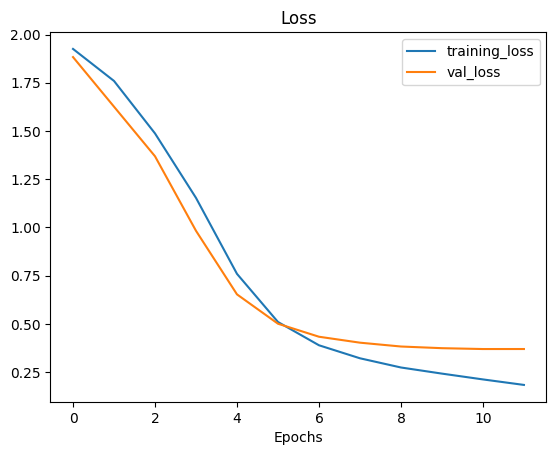

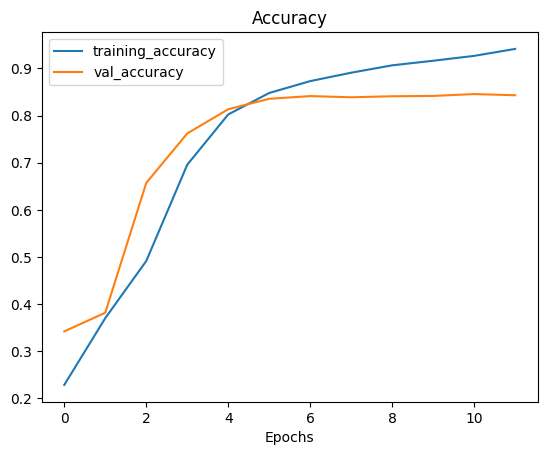

In [29]:
plot_loss_curves(model_history)

In [30]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [51]:
sentence = ["i neutral"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen = 100, padding = "post")

In [52]:
padded

array([[  1, 565,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=int32)

In [53]:
model.predict(padded)

1/1 [==============================] - 0s 17ms/step


array([[0.01067317, 0.0143013 , 0.03885212, 0.01439134, 0.02083762,
        0.00335303, 0.8975915 ]], dtype=float32)

In [54]:
model.save("model_final.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [55]:
export_dir = '\content'
tf.saved_model.save(model, export_dir)

In [56]:
mode = "Speed"

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT


In [57]:
model_final = tf.keras.models.load_model('model_final.h5')

In [58]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model_final) # path to the SavedModel directory
converter.optimizations = [optimization]
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()


In [59]:
import pathlib

In [60]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

3477704